# Dynamic Unbalanced Optimal Transport Using Proximal Splitting

In this notebook, we test our code for UOT with proximal splitting. The algorithm and the code is based on Chizat et al. (2018).


In [7]:
import numpy as np
import scipy as sp
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
def plot_1D(t, x, v, g, X, rho_0, rho_1, ylim=[-2, 2], title=""):
    plt.figure(figsize=[16, 4])

    # Fill plots
    if rho_0 is not None:
        plt.fill_between(X, rho_0, color="k", alpha=0.2, label=r'$\rho_0$')
    if rho_1 is not None:
        plt.fill_between(X, rho_1, color="b", alpha=0.2, label=r'$\rho_1$')
    plt.fill_between(X, x.V.D[0][t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')

    # Line plots
    plt.plot(X, v[0][t, :], "k", label=r'$v_t$')
    plt.plot(X, g[t, :], "g", label=r'$g_t$')
    plt.title(title)
    plt.axis([0, 1, ylim[0], ylim[1]])
    plt.show()

# Experiment 1. Recreation of "Travelling Gaussian bumps in 1d" in Chizat et al. (2018)
We will recreate their result regarding the OT of travelling Gaussian bumps.

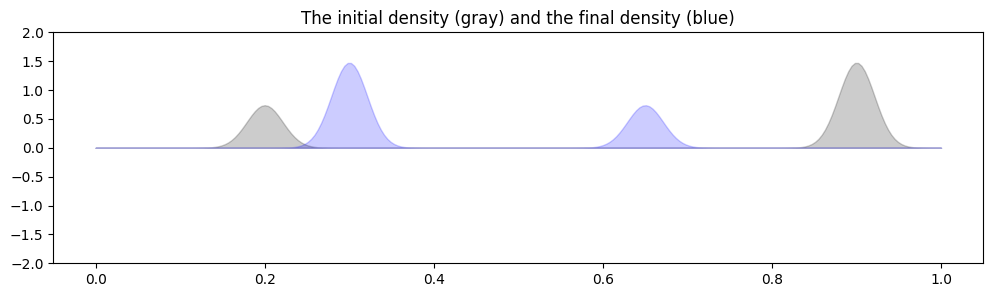

In [3]:
# Plotting initial and the final density

sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.2, sigma, 1) + gauss(X, 0.9, sigma, 2)  # Initial density
rho_1 = gauss(X, 0.3, sigma, 2) + gauss(X, 0.65, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 30
rho_1 /= np.sum(rho_1) / 30

# Plotting
plt.figure(figsize=(12, 3))
plt.ylim(-2, 2)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

In [6]:
T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=0.5/np.pi, niter=3000)

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


In [7]:
v,g = speed_and_growth(x.V)
plot_elements1 = [x.copy(), v.copy(), g.copy(), X.copy(), rho_0.copy(), rho_1.copy(), [-2,2], r"(grey) $\rho_0$, (blue) $\rho_1$ (red) $\rho_t$ (green) $g_t$ (dark) $v_t$"]
interact(lambda t: plot_1D(t, *plot_elements1), t=widgets.IntSlider(min=0, max=T-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=14), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

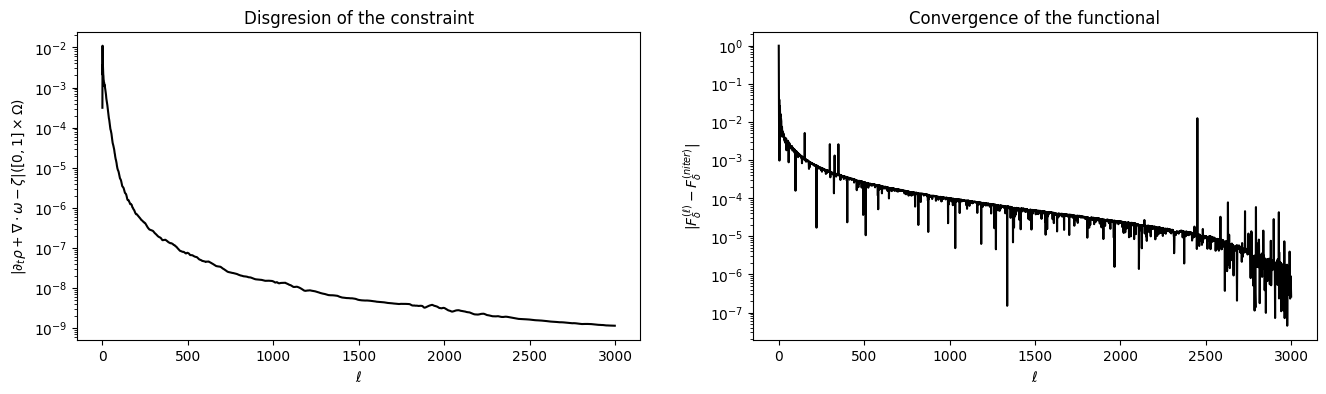

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|([0,1]\times \Omega)$")
plt.xlabel(r"$\ell$")
plt.title("Disgresion of the constraint")
plt.semilogy(lists[1], "k")

plt.subplot(1, 2, 2)
plt.ylabel(r"$|F_{\delta}^{(\ell)}-F_{\delta}^{(niter)}|$")
plt.xlabel(r"$\ell$")
plt.title("Convergence of the functional")
minF = np.min(lists[0][-10:])
plt.semilogy(np.minimum(1, np.abs(lists[0] - np.mean(lists[0][-10:]))), "k")

plt.show()

## Experiment 2: Total Mass Constraint $\rho_t(\Omega) = 2(t-1/2)^2 +1/2$ between the same distribution
In this experiment, we consider the "transport" of the same distribution but with the total mass constraint. As a result, the distribution should shrink and come back. 

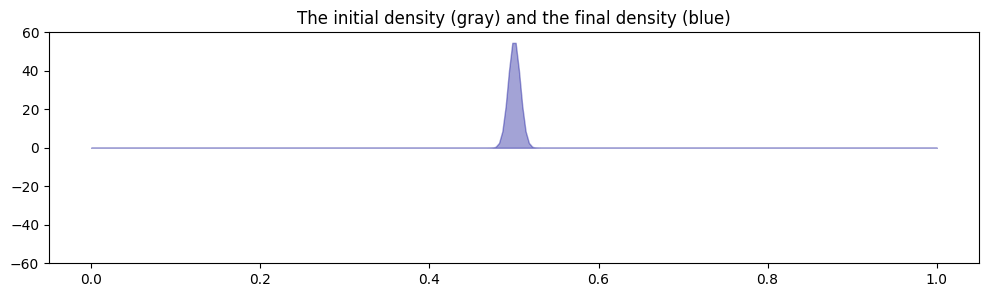

In [9]:
# Plotting initial and the final density

sigma = 0.01
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.5, sigma, 1) # Initial density
rho_1 = gauss(X, 0.5, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / 256

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(12, 3))
plt.ylim(-60, 60)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

In [10]:
T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
H = np.ones((T,K))
time = np.array([(i+0.5)/T for i in range(0,T)])
F = 2*(time - 0.5)**2 + 0.5
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=0.5/np.pi, niter=3000)

Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


In [12]:
v,g = speed_and_growth(x.V)
plot_elements2 = [x.copy(), 10*v.copy(), 10*g.copy(), X.copy(), None, None, [-60,60], r"(red) $\rho_t$ (green) $10g_t$ (dark) $10v_t$"]
interact(lambda t: plot_1D(t, *plot_elements2), t=widgets.IntSlider(min=0, max=T-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=14), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

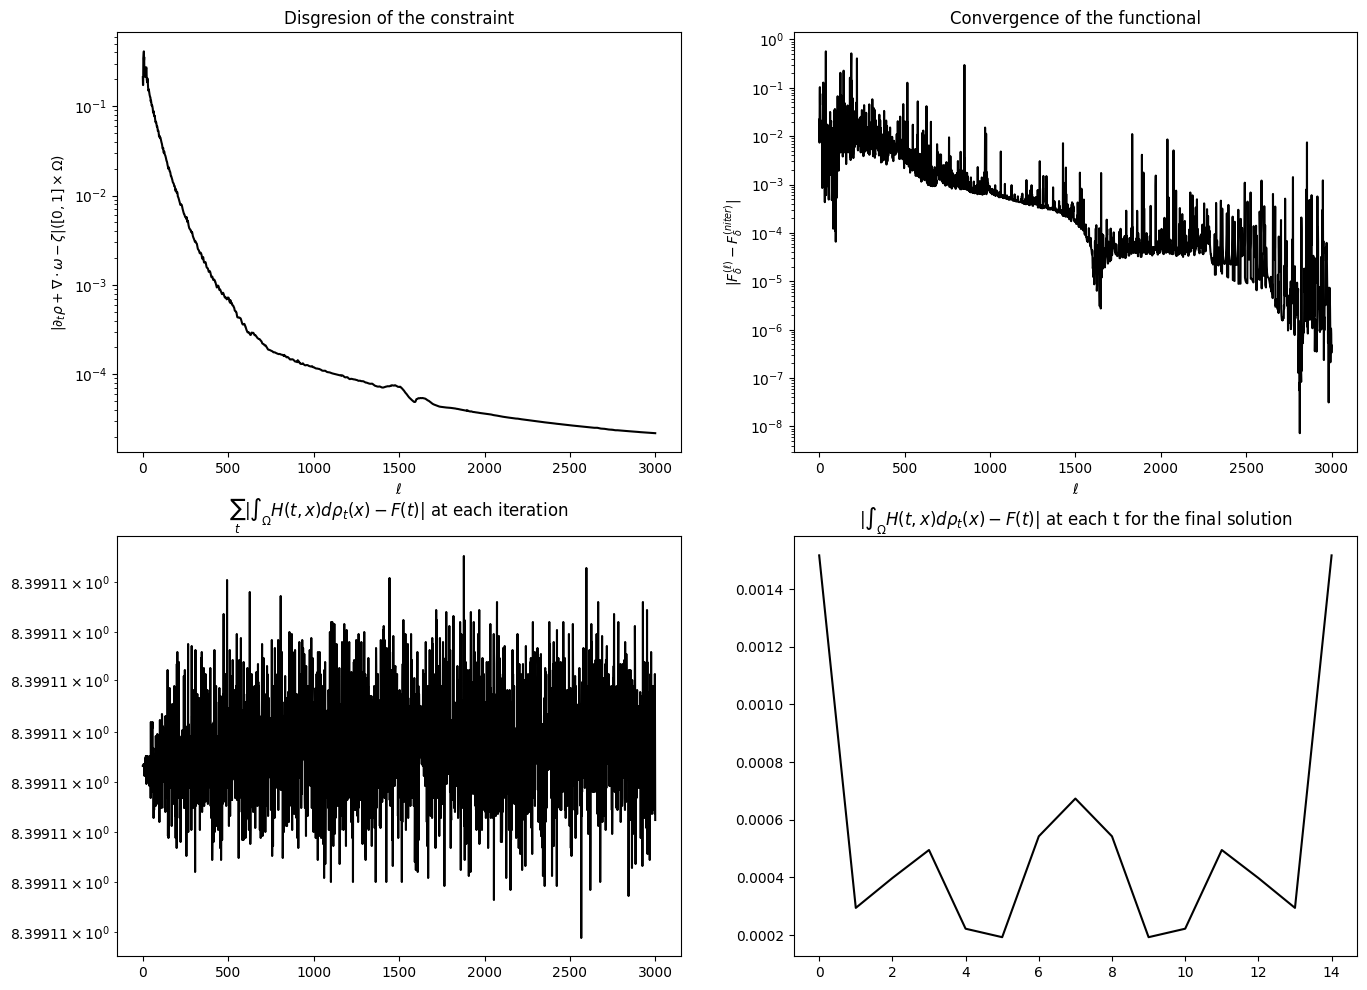

In [13]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|([0,1]\times \Omega)$")
plt.xlabel(r"$\ell$")
plt.title("Disgresion of the constraint")
plt.semilogy(lists[1], "k")

plt.subplot(2, 2, 2)
plt.ylabel(r"$|F_{\delta}^{(\ell)}-F_{\delta}^{(niter)}|$")
plt.xlabel(r"$\ell$")
plt.title("Convergence of the functional")
minF = np.min(lists[0][-10:])
plt.semilogy(np.minimum(1, np.abs(lists[0] - np.mean(lists[0][-10:]))), "k")

plt.subplot(2, 2, 3)
plt.title("$\sum_{t}|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each iteration")
plt.semilogy(lists[2], "k")

plt.subplot(2, 2, 4)
plt.title("$|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each t for the final solution")
plt.plot(np.abs(np.sum(x.V.D[0]*H, axis=1)*1./256.-F), "k")

plt.show()



# Experiment 3: Transport of Diracs (Unconstrained)
In the relaxation approach, it has been noticed that highly nonsmooth distributions such as Dirac measures cause issues. We will see if it is still the case here for the unconstrained case. 

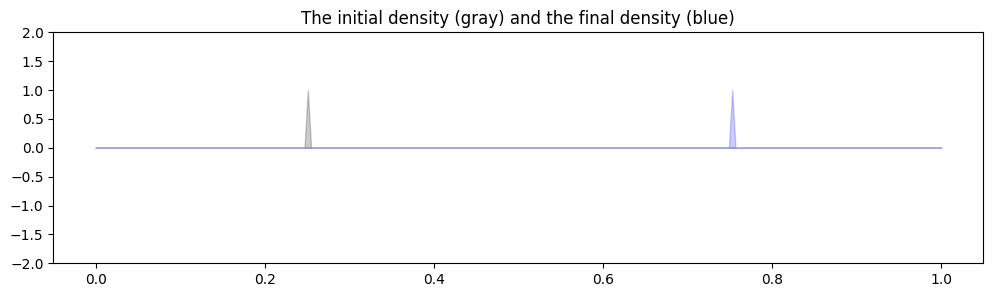

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


In [14]:
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

rho_0 = np.zeros(K)
rho_0[64] = 1
rho_1 = np.roll(rho_0,128)

# Plotting
plt.figure(figsize=(12, 3))
plt.ylim(-2, 2)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=1.0, niter=3000)

In [15]:
v,g = speed_and_growth(x.V)
plot_elements3 = [x.copy(), v.copy(), g.copy(), X.copy(), rho_0.copy(), rho_1.copy(), [-2,2], r"(grey) $\rho_0$, (blue) $\rho_1$ (red) $\rho_t$ (green) $g_t$ (dark) $v_t$"]
interact(lambda t: plot_1D(t, *plot_elements3), t=widgets.IntSlider(min=0, max=T-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=14), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

 We notice that the mass gets flattened, transported and comes back. This is against the theoretical result as proven by Chizat et al. where the Dirac just transports. This shows that the proximal solver is still weak against Dirac transportation.

# Experiment 4: Recreation of "Deformation fo a ring"

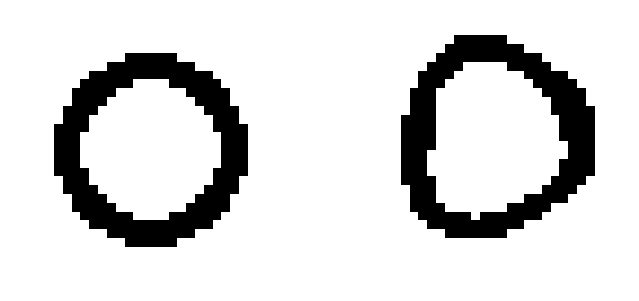

sum(ρ_0) = 188.0,
sum(ρ_1) = 190.0


In [16]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

# Create a ring
N = 32
σ = N / 100
x = np.linspace(-1., 1., N)
y = np.linspace(-1., 1., N)
xx, yy = np.meshgrid(x, y)
ff = lambda x, y: 1.0 * ((1/4 < x**2 + y**2) & (x**2 + y**2 < 1/2))
ρ_0 = ff(xx, yy).astype(np.float64)

# Smooth deformation field
ker = np.exp(-x**2 / σ**2) / np.sqrt(2 * np.pi * σ**2) / 10
ker = ker[:, np.newaxis] * ker[np.newaxis, :]
indN = N // 2

def smooth_field(field):
    field = convolve(field, ker, mode='reflect')
    field = convolve(field, ker, mode='reflect')
    return field

v1 = smooth_field(np.random.randn(N, N))
v2 = smooth_field(np.random.randn(N, N))

def push(x, y):
    xi = min(max(int(np.floor(x * N / 2 + N / 2)), 0), N-1)
    yi = min(max(int(np.floor(y * N / 2 + N / 2)), 0), N-1)
    return (x + v1[xi, yi], y + v2[xi, yi])

x_push = np.linspace(-.99, .99, N)
y_push = np.linspace(-.99, .99, N)
xx_push, yy_push = np.meshgrid(x_push, y_push)
ρ_1 = np.array([ff(*push(x, y)) for x, y in zip(np.ravel(xx_push), np.ravel(yy_push))]).reshape(N, N)

# Plot
plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.imshow(ρ_0, cmap="Greys")
plt.axis("off")
plt.subplot(122)
plt.imshow(ρ_1, cmap="Greys")
plt.axis("off")
plt.show()

sum_ρ_0 = np.sum(ρ_0)
sum_ρ_1 = np.sum(ρ_1)

print(f"sum(ρ_0) = {sum_ρ_0},\nsum(ρ_1) = {sum_ρ_1}")

In [17]:
T = 20
ll=(1.0, 1.0, 1.0)
x, lists = computeGeodesic(ρ_0, ρ_1, T, ll, p= 2.0, q=2.0, delta=0.5/np.pi, niter=1500)

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


In [18]:
import ipywidgets as widgets
from ipywidgets import interact
v, g = speed_and_growth(x.V)

X = np.linspace(0, 1, x.cs[1])
Y = np.linspace(0, 1, x.cs[2])

def plot_ring(t, x, g, X, Y):
    f, axes = plt.subplots(1, 3, figsize=[10, 2.5])

    ax1, ax2, ax3 = axes

    # Density plot
    ax1.pcolormesh(X, Y, x.V.D[0][t, :, :], cmap="gray_r")
    ax1.axis("off")
    ax1.set_title(r"Density $\rho_t$")

    # Growth plot
    ax2.pcolormesh(X, Y, g[t, :, :], cmap="bwr", vmin=-2, vmax=2)
    ax2.axis("off")
    ax2.set_title("Growth")

    # Velocity plot
    ax3.quiver(X, Y, x.V.D[2][t, :, :], x.V.D[1][t, :, :], x.V.D[0][t, :, :], cmap="gray_r")
    ax3.axis("off")
    ax3.set_title("Velocity")

    plt.show()

# Interactive widget
plot_elements4 = [x.copy(), g.copy(), X.copy(), Y.copy()]
interact(lambda t: plot_ring(t, *plot_elements4), t=widgets.IntSlider(min=0, max=T-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=19), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

# Example 5: Maze Solver
We try the maze solver example that failed for the relaxation method.

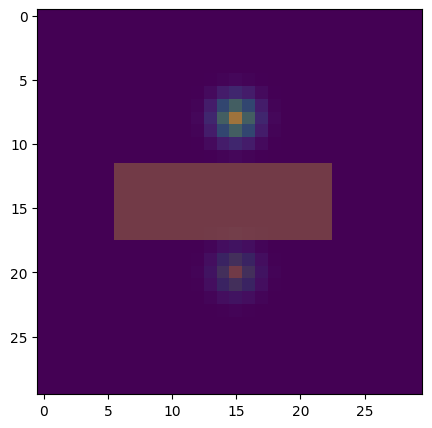

In [9]:
import scipy as sp
from PIL import Image

def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

maze = (1-image_to_numpy('maze2.png').squeeze()/255)

T = 60
N1 = maze.shape[0]
N2 = maze.shape[1]

H = np.repeat(maze[np.newaxis, :, :], T, axis=0)
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[15./30., 20./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[15./30., 8./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()  

In [10]:
ll=(1.0, 1.0, 1.0)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1.0, niter=3000)

Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


In [11]:
def plot_maze_1(t, x, maze, xx, yy, rho_0, rho_1, ismask=False):
    f, axes = plt.subplots(1, 3, figsize=[10, 5])

    ax1, ax2, ax3 = axes
    if t<=0:
        ax1.imshow(rho_0)
        ims2 = ax2.imshow(x.V.Z[0], vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][0], x.V.D[1][0], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    elif t>=T:
        ax1.imshow(rho_1)
        ims2 = ax2.imshow(x.V.Z[T-1], vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][T-1], x.V.D[1][T-1], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    else:
        masked1 = np.ma.masked_where(np.abs(x.V.D[0][t]) < 1e-3 , x.V.D[0][t])
        if ismask:
            ax1.imshow(masked1)
        else:
            ax1.imshow(x.V.D[0][t])
        masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-3 , x.V.Z[t])
        cmap = plt.cm.viridis
        cmap.set_bad(color='white')  # Set color for masked values (zero values)
        ims2 = ax2.imshow(masked, vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][t], x.V.D[1][t], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    ax1.imshow(maze, alpha=0.5)

    plt.show()

plot_elements5 = [x.copy(), maze.copy(), xx, yy, rho_0.copy(), rho_1.copy()]
interact(lambda t: plot_maze_1(t, *plot_elements5), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=60), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

# Example 6: Maze Solver 2

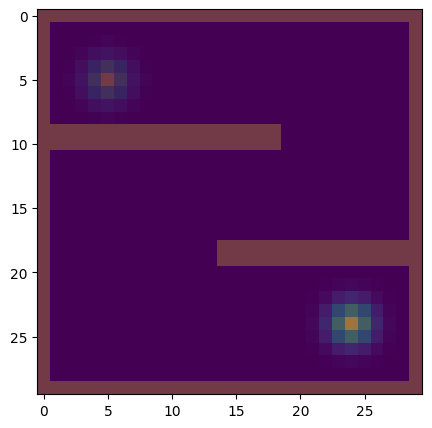

In [184]:
import scipy as sp
from PIL import Image

def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

maze = (1-image_to_numpy('maze.png').squeeze()/255)

T = 60
N1 = maze.shape[0]
N2 = maze.shape[1]

H = np.repeat(maze[np.newaxis, :, :], T, axis=0)
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 5./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 24./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()  

In [188]:
ll=(1.0, 1.0, 1.0)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1.0, niter=7000)
#y, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1.0, niter=10000)

Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


In [189]:
def plot_maze_1(t, x, maze, xx, yy, rho_0, rho_1, ismask=False):
    f, axes = plt.subplots(1, 3, figsize=[10, 5])

    ax1, ax2, ax3 = axes
    if t<=0:
        ax1.imshow(rho_0)
        ims2 = ax2.imshow(x.V.Z[0], vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][0], x.V.D[1][0], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    elif t>=T:
        ax1.imshow(rho_1)
        ims2 = ax2.imshow(x.V.Z[T-1], vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][T-1], x.V.D[1][T-1], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    else:
        masked1 = np.ma.masked_where(np.abs(x.V.D[0][t]) < 1e-3 , x.V.D[0][t])
        if ismask:
            ax1.imshow(masked1)
        else:
            ax1.imshow(x.V.D[0][t])
        masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-3 , x.V.Z[t])
        cmap = plt.cm.viridis
        cmap.set_bad(color='white')  # Set color for masked values (zero values)
        ims2 = ax2.imshow(masked, vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][t], x.V.D[1][t], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    ax1.imshow(maze, alpha=0.5)

    plt.show()


plot_elements6 = [x.copy(), maze.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
#plot_elements7 = [y.copy(), maze.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
interact(lambda t: plot_maze_1(t, *plot_elements6), t=widgets.IntSlider(min=0, max=T, step=1, value=0))
interact(lambda t: plot_maze_1(t, *plot_elements7), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=60), Output()), _dom_classes=('widget-interact',…

interactive(children=(IntSlider(value=0, description='t', max=60), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

# Experiment 7: CIRM special

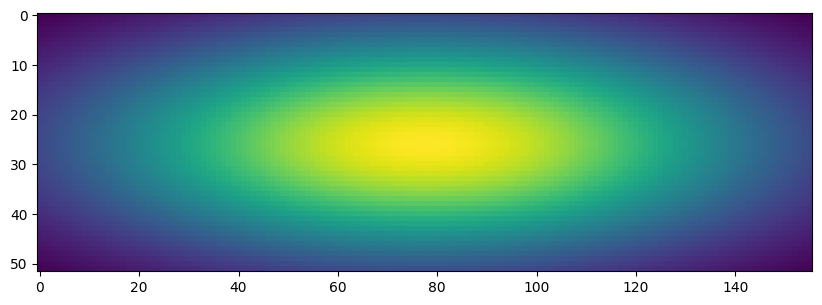

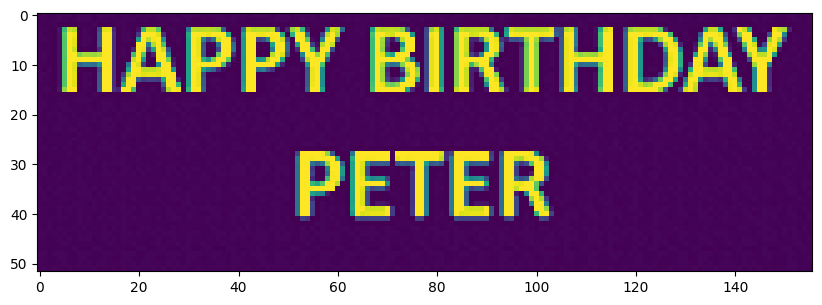

In [15]:
import scipy as sp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

indicesx = np.arange(0, 156) * 1./156
indicesy = np.arange(0, 52) * 1./52
xx, yy = np.meshgrid(indicesx, indicesy)

rho_1 = (1-image_to_numpy('HAPPY BIRTHDAY PETER.png').squeeze()/255)
rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[78./156., 26./52.], cov=0.1)

rho_0 = rho_0 / np.sum(rho_0)
rho_1 = rho_1 / np.sum(rho_1)

T = 100
N1 = rho_1.shape[0]
N2 = rho_1.shape[1]

# plot rho_0 and rho_1
plt.figure(figsize=(10, 5))
plt.imshow(rho_0)
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(rho_1)
plt.show()

In [16]:
ll = (1.0, 1.0, 3.0)

x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=1.0, niter=3000)

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


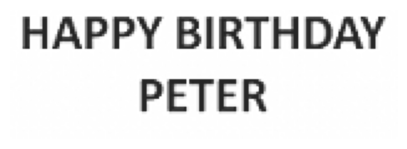

In [17]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import numpy as np

cmap = plt.cm.Greys

# Assuming plot_elements8, rho_0, rho_1, and T are defined elsewhere

global_min = min(rho_0.min(), rho_1.min(), x.V.D[0].min())
global_max = max(rho_0.max(), rho_1.max(), x.V.D[0].max())

fig, ax = plt.subplots(figsize=(5, 10))

def init():
    if T <= 0:
        im = ax.imshow(rho_0, cmap=cmap, vmin=global_min, vmax=global_max)
    else:
        im = ax.imshow(rho_1, cmap=cmap, vmin=global_min, vmax=global_max)
    ax.axis('off')  # Remove the axis
    return [im]

def update(t):
    ax.clear()
    if t <= 0:
        im = ax.imshow(rho_0, cmap, vmin=global_min, vmax=global_max)
    elif t >= T:
        im = ax.imshow(rho_1, cmap, vmin=global_min, vmax=global_max)
    else:
        im = ax.imshow(x.V.D[0][t], cmap, vmin=global_min, vmax=global_max)
    ax.axis('off')  # Remove the axis
    return [im]

ani = FuncAnimation(fig, update, frames=np.arange(0, T+1), init_func=init, blit=True)

# Save as GIF
ani.save('cirm_special.gif', writer=PillowWriter(fps=10))

# Save as MP4
ani.save('cirm_special.mp4', writer=FFMpegWriter(fps=10))

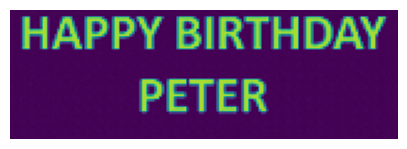

In [18]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import numpy as np

cmap = plt.cm.viridis

# Assuming plot_elements8, rho_0, rho_1, and T are defined elsewhere

global_min = min(rho_0.min(), rho_1.min(), x.V.D[0].min())
global_max = max(rho_0.max(), rho_1.max(), x.V.D[0].max())

fig, ax = plt.subplots(figsize=(5, 10))

def init():
    if T <= 0:
        im = ax.imshow(rho_0, cmap=cmap, vmin=global_min, vmax=global_max)
    else:
        im = ax.imshow(rho_1, cmap=cmap, vmin=global_min, vmax=global_max)
    ax.axis('off')  # Remove the axis
    return [im]

def update(t):
    ax.clear()
    if t <= 0:
        im = ax.imshow(rho_0, cmap, vmin=global_min, vmax=global_max)
    elif t >= T:
        im = ax.imshow(rho_1, cmap, vmin=global_min, vmax=global_max)
    else:
        im = ax.imshow(x.V.D[0][t], cmap, vmin=global_min, vmax=global_max)
    ax.axis('off')  # Remove the axis
    return [im]

ani = FuncAnimation(fig, update, frames=np.arange(0, T+1), init_func=init, blit=True)

# Save as GIF
ani.save('cirm_special_viridis.gif', writer=PillowWriter(fps=10))

# Save as MP4
ani.save('cirm_special_viridis.mp4', writer=FFMpegWriter(fps=10))

# Expriment 8: Moving Barrier

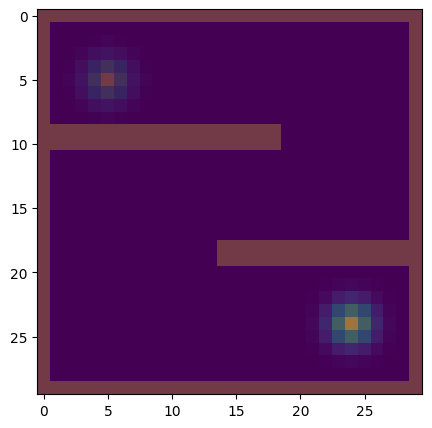

In [2]:
import scipy as sp
from PIL import Image

def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

maze = (1-image_to_numpy('maze.png').squeeze()/255)

T = 30
N1 = maze.shape[0]
N2 = maze.shape[1]

H = np.repeat(maze[np.newaxis, :, :], T, axis=0)
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 5./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 24./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()  

13
13
12
12
11
11
10
10
9
9
8
8
7
7
7
6
6
5
5
4
4
3
3
2
2
1
1
0
0


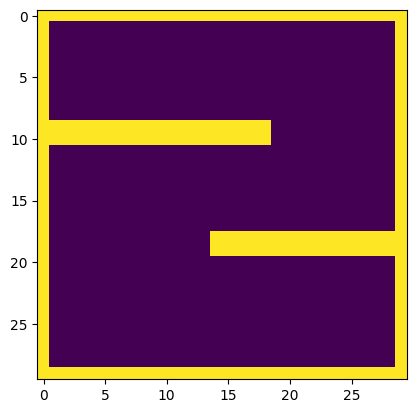

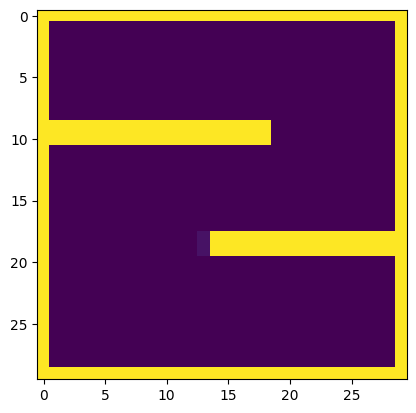

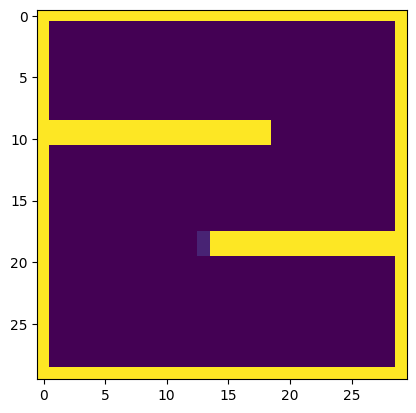

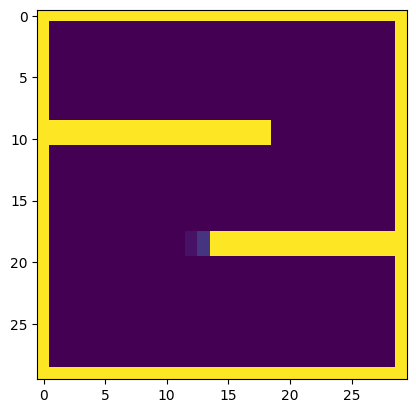

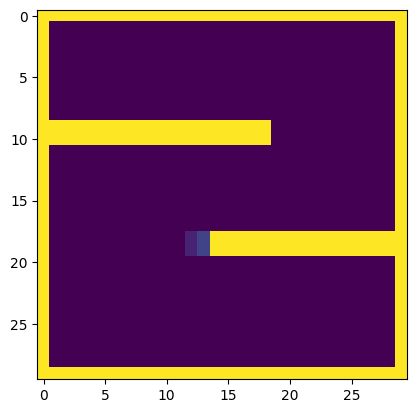

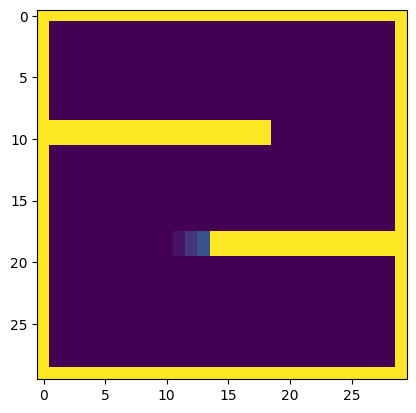

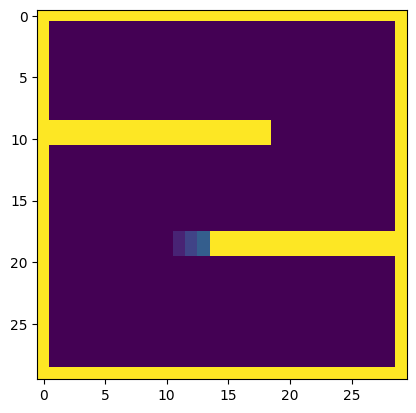

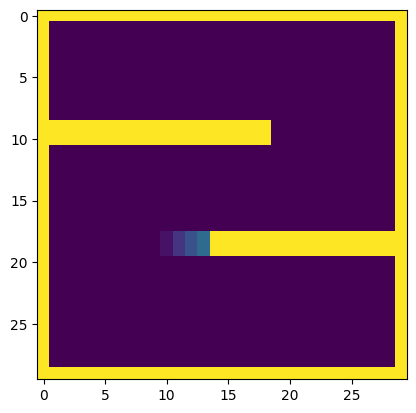

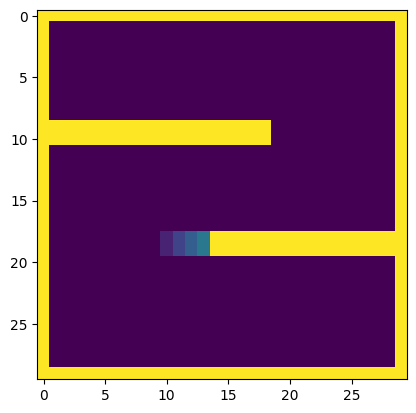

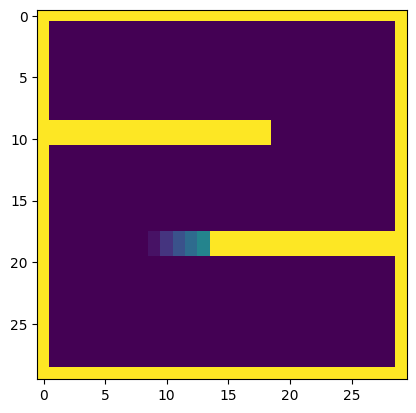

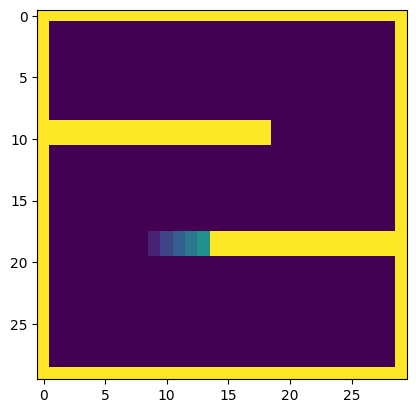

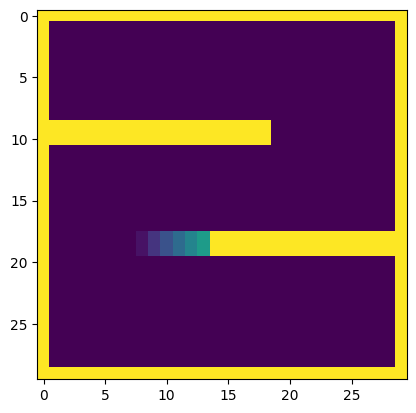

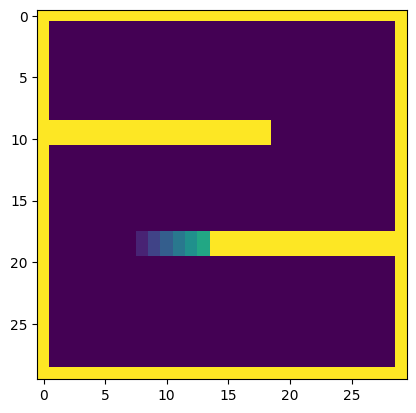

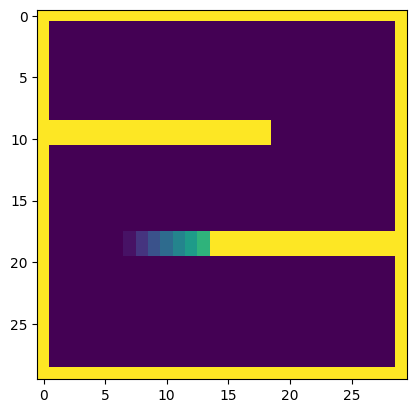

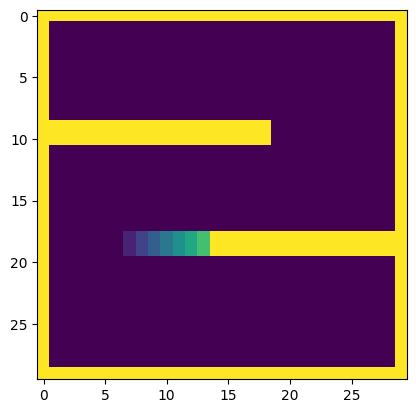

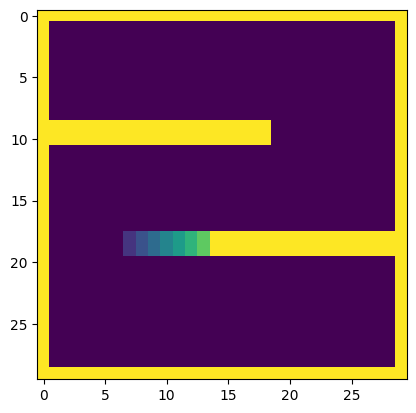

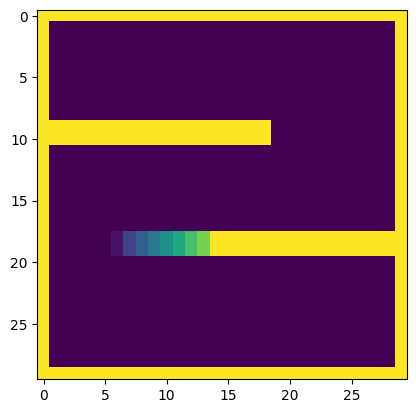

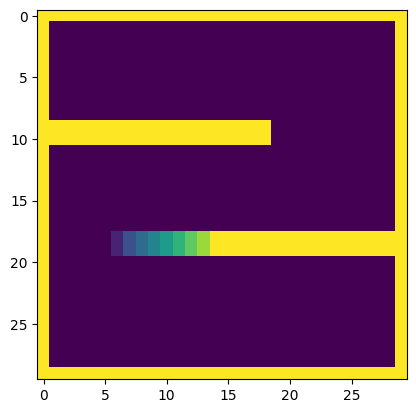

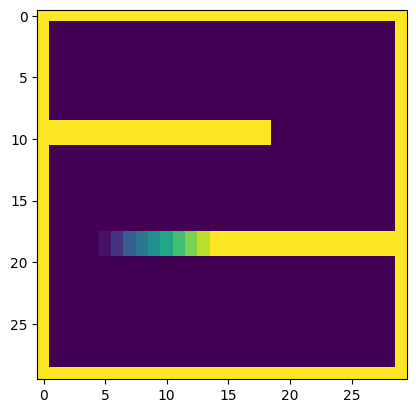

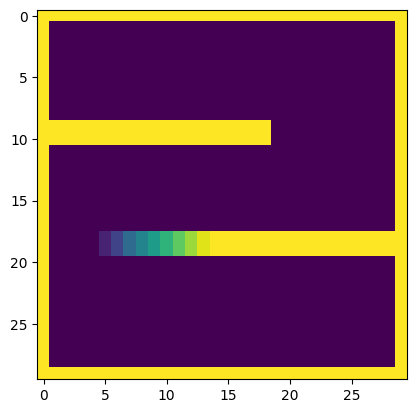

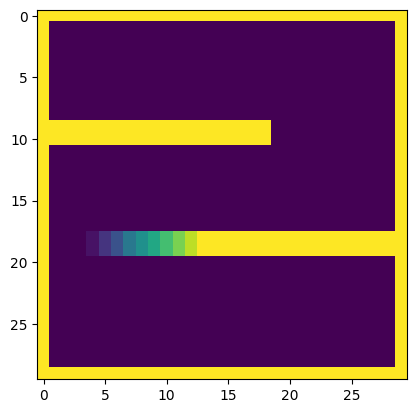

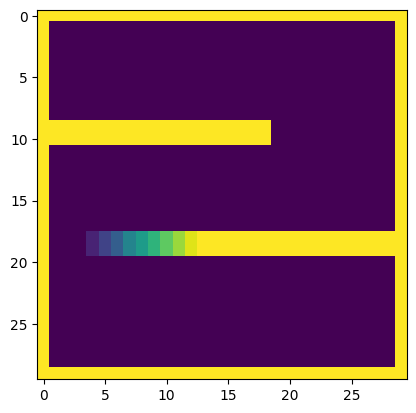

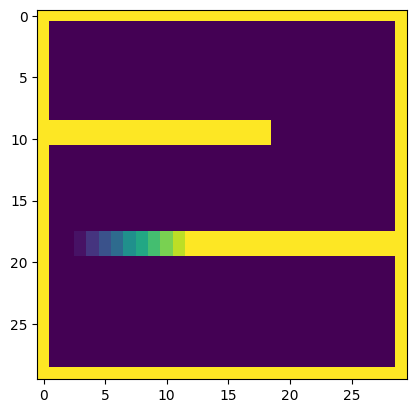

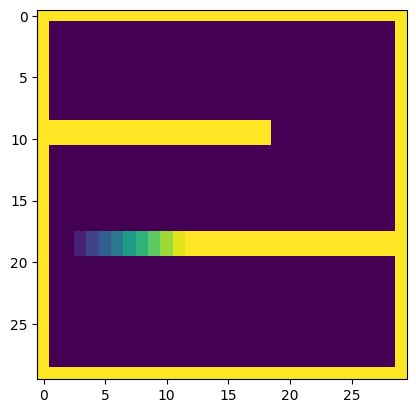

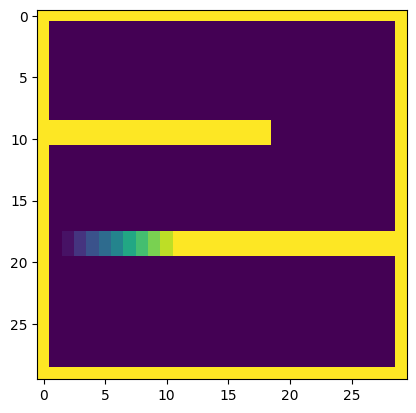

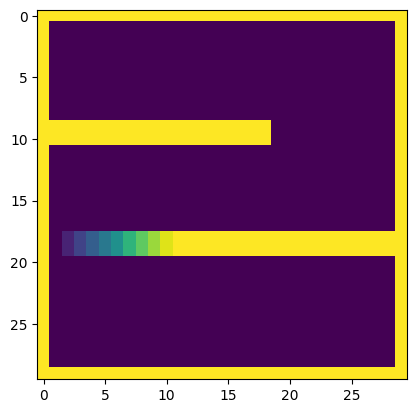

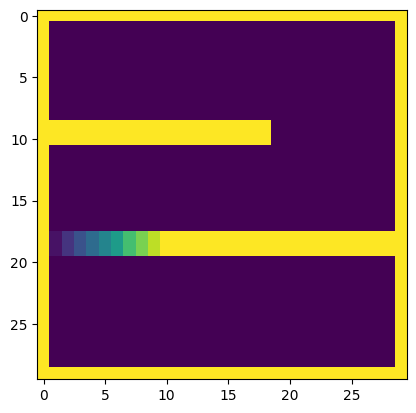

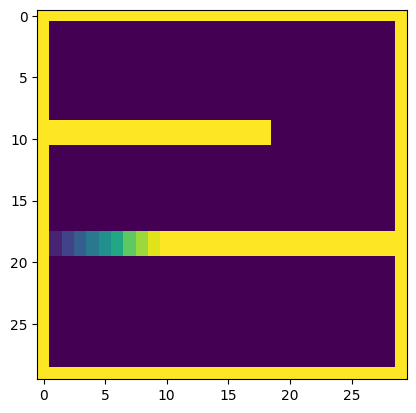

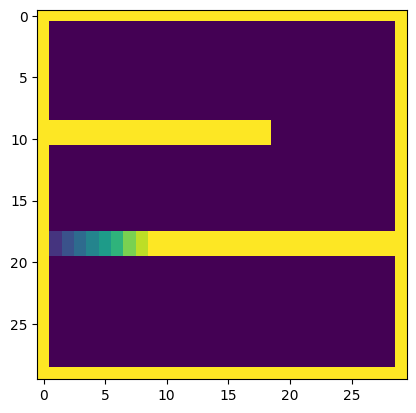

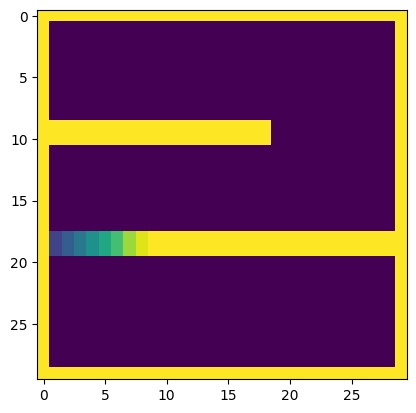

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def fill_region(frames, fps, speed, original, Hstep):
    rows, cols = 30, 30
    step_size = speed*14/fps

    # Define the region to fill
    start_col, end_col = 1, 14

    # Create a list to store each frame
    filled_frames = [original]

    for i in range(1,frames):
        frame = filled_frames[-1].copy()
        # Determine the slice to fill based on speed
        print(int(end_col - i*step_size))
        end_fill = max(1, int(end_col - i*step_size))
        frame[18:20, end_fill:14] += Hstep
        # if above 1, clip to 1
        frame[frame > 1] = 1
        
        # Append the current state of the array to the list
        filled_frames.append(frame.copy())
    
    return filled_frames

def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames), figsize=(15, 5))
    for idx, frame in enumerate(frames):
        ax = axes[idx]
        ax.imshow(frame, cmap='viridis', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f'Frame {idx + 1}')
    plt.tight_layout()
    plt.show()


# Generate frames
frames = fill_region(T, 30, 1.0, maze, Hstep=0.05)

H = np.stack(frames, axis=0)

# Plot frames
for i in range(T):
    plt.imshow(H[i])
    plt.show()


In [91]:
ll=(1.0, 1.0, 1.0)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1.0, niter=15000) #alpha = 0.018, gamma = max(rho_0.max(), rho_1.max())/15)

Computing a geodesic for optimal transport with source and constraint...
Progress: 99%
Done.


In [92]:
print(x.V.Z.min(), x.V.Z.max())
print(x.V.D[1].min(), x.V.D[1].max())
print(x.V.D[2].min(), x.V.D[2].max())

-41.29671927331123 117.89471759708299
-107.90844045664156 200.3168076573386
-237.90983021540967 146.25185726552422


In [93]:
def plot_maze_2(t, x, H, xx, yy, rho_0, rho_1, ismask=False):
    f, axes = plt.subplots(1, 3, figsize=[10, 5])

    ax1, ax2, ax3 = axes
    if t<=0:
        ax1.imshow(H[0])
        ax1.imshow(rho_0, alpha=0.5)
        ims2 = ax2.imshow(x.V.Z[0], vmin=-40, vmax=40)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][0], x.V.D[1][0], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    elif t>=T:
        ax1.imshow(H[T-1])
        ax1.imshow(rho_1, alpha=0.5)
        ims2 = ax2.imshow(x.V.Z[T-1], vmin=-5, vmax=5)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][T-1], x.V.D[1][T-1], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
    else:
        masked1 = np.ma.masked_where(np.abs(x.V.D[0][t]) < 1e-3 , x.V.D[0][t])
        if ismask:
            ax1.imshow(masked1)
        else:
            ax1.imshow(H[t])
            ax1.imshow(x.V.D[0][t], alpha=0.5)
        masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-3 , x.V.Z[t])
        cmap = plt.cm.viridis
        cmap.set_bad(color='white')  # Set color for masked values (zero values)
        ims2 = ax2.imshow(masked, vmin=-5, vmax=5)
        cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
        ax3.quiver(xx, yy, x.V.D[2][t], x.V.D[1][t], cmap="gray_r")
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')

    plt.show()


plot_elements9 = [x.copy(), H.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
interact(lambda t: plot_maze_2(t, *plot_elements9), t=widgets.IntSlider(min=0, max=T, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=30), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

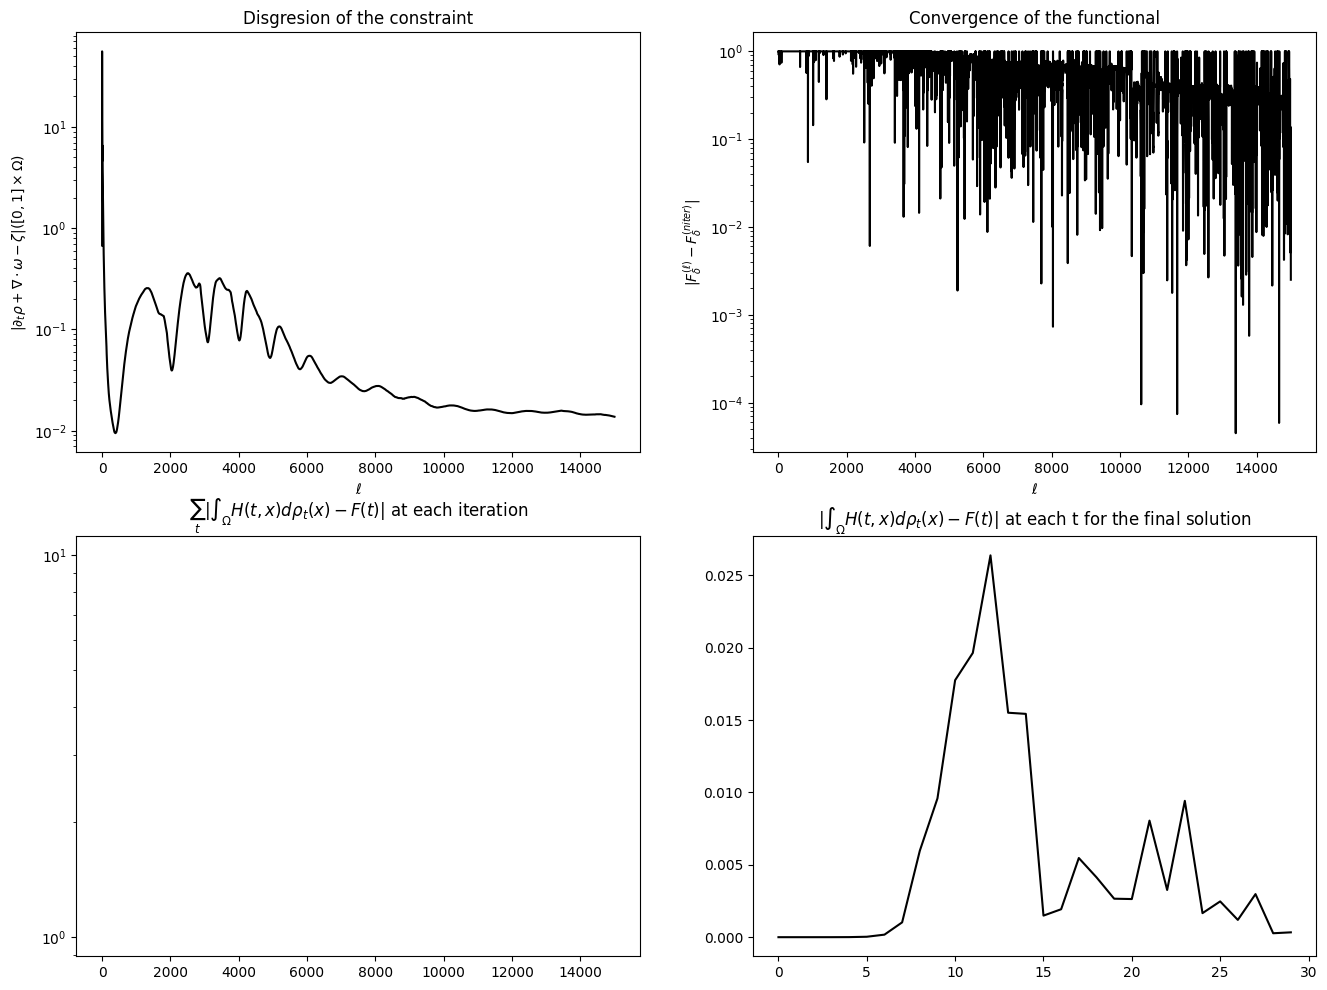

In [94]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.ylabel(r"$|\partial_t \rho + \nabla \cdot \omega - \zeta|([0,1]\times \Omega)$")
plt.xlabel(r"$\ell$")
plt.title("Disgresion of the constraint")
plt.semilogy(lists[1], "k")

plt.subplot(2, 2, 2)
plt.ylabel(r"$|F_{\delta}^{(\ell)}-F_{\delta}^{(niter)}|$")
plt.xlabel(r"$\ell$")
plt.title("Convergence of the functional")
minF = np.min(lists[0][-10:])
plt.semilogy(np.minimum(1, np.abs(lists[0] - np.mean(lists[0][-10:]))), "k")

plt.subplot(2, 2, 3)
plt.title("$\sum_{t}|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each iteration")
plt.semilogy(lists[2], "k")

plt.subplot(2, 2, 4)
plt.title("$|\int_{\Omega}H(t,x)d\\rho_t(x)-F(t)|$ at each t for the final solution")
plt.plot(np.abs(np.sum(x.V.D[0]*H, axis=(1,2))*1./900.-F), "k")

plt.show()



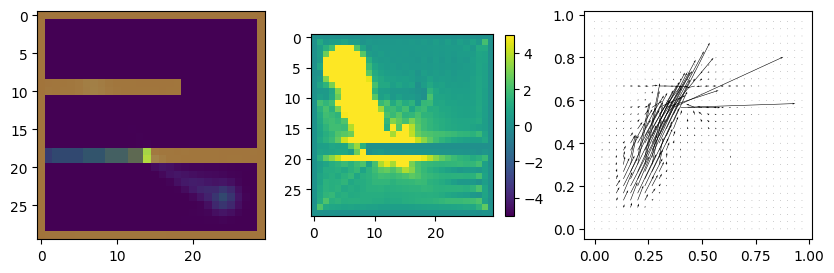

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

def plot_maze_2(x, H, xx, yy, rho_0, rho_1, ismask=False):
    T = len(H)
    f, axes = plt.subplots(1, 3, figsize=[10, 5])

    ax1, ax2, ax3 = axes

    # Initialize images and colorbar
    im1 = ax1.imshow(H[0])
    im2 = ax1.imshow(rho_0, alpha=0.5)
    ims2 = ax2.imshow(x.V.Z[0], vmin=-5, vmax=5)
    cbar1 = f.colorbar(ims2, ax=ax2, shrink=0.47)
    quiv = ax3.quiver(xx, yy, x.V.D[2][0], x.V.D[1][0], cmap="gray_r")

    def init():
        #ax1.imshow(H[0])
        #ax1.imshow(rho_0, alpha=0.5)
        ims2.set_data(x.V.Z[0])
        quiv.set_UVC(x.V.D[2][0], x.V.D[1][0])
        ax3.invert_yaxis()
        ax3.set_aspect('equal', adjustable='box')
        return im1, im2, ims2, quiv

    def update(t):

        if t <= 0:
            im1.set_data(H[0])
            im2.set_data(rho_0)
            ims2.set_data(x.V.Z[0])
            quiv.set_UVC(x.V.D[2][0], x.V.D[1][0])
        elif t >= T:
            im1.set_data(H[T-1])
            im2.set_data(rho_1)
            ims2.set_data(x.V.Z[T-1])
            quiv.set_UVC(x.V.D[2][T-1], x.V.D[1][T-1])
        else:
            masked1 = np.ma.masked_where(np.abs(x.V.D[0][t]) < 1e-10, x.V.D[0][t])
            if ismask:
                im1.set_data(masked1)
            else:
                im1.set_data(H[t])
                im2.set_data(x.V.D[0][t])
            masked = np.ma.masked_where(np.abs(x.V.Z[t]) < 1e-10, x.V.Z[t])
            cmap = plt.cm.viridis
            cmap.set_bad(color='white')  # Set color for masked values (zero values)
            ims2.set_data(masked)
            quiv.set_UVC(x.V.D[2][t], x.V.D[1][t])
        return im1, im2, ims2, quiv

    ani = FuncAnimation(f, update, frames=range(T), init_func=init, blit=False)
    ani.save('maze_animation.mp4', writer='ffmpeg', fps=15)

# Example usage
plot_elements9 = [x.copy(), H.copy(), xx, yy, rho_0.copy(), rho_1.copy(), False]
plot_maze_2(*plot_elements9)
